<a href="https://colab.research.google.com/github/Markfesenk0/MLHC-Project/blob/main/MLHC_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Student Details

|        |             Full Name |             Id |             Email |
|---------|-------------------|----------------|------------------ |
|Student 1|   Mark Fesenko|  321208605|  markfesenko@mail.tau.ac.il|
|Student 2|   |  |  |

In [1]:
%%capture

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table
from google.colab import widgets
from google.colab.data_table import DataTable
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import pandas as pd
import math
import pickle
import os
import json
from collections import Counter
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
!pip install shap
!pip install shap xgboost imbalanced-learn
import shap

DataTable.max_columns = 200

project = 'mimic-iii-i'
client = bigquery.Client(project=project)
data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [2]:
min_target_onset = 48       # minimal time of target since admission (hours)
pred_gap = 6                # minimal gap between prediction and target (hours)
pred_window = 42            # duration of prediction window, use only data collected in the first 42 hours for prediction
min_los = 48                # only patients with at least >= 48 hours of hospitalization data
mortality_window = 30              # mortality during or after hospitalization <= 30 days
prolonged_stay = 7          # prolonged stay > 7 days
hospital_readmission = 30   # hospital readmission in <= 30 days after discharge (not to be confused with ICU readmission within the same hospital admission)

In [3]:
# download additional files neede for the project

!gdown 1QBKgf3B_bOthZmMPu2NSDplo7DlcQ3Lo
!unzip -o project_addons.zip

plots_directory = './figures'
os.makedirs(plots_directory, exist_ok=True)

Downloading...
From: https://drive.google.com/uc?id=1QBKgf3B_bOthZmMPu2NSDplo7DlcQ3Lo
To: /content/project_addons.zip
100% 89.0k/89.0k [00:00<00:00, 64.1MB/s]
Archive:  project_addons.zip
  inflating: test_example.csv        
  inflating: vital_metadata.csv      
  inflating: initial_cohort.csv      
  inflating: labs_metadata.csv       


In [4]:
# @title Query DB - Patients
hospquery = \
"""
SELECT admissions.subject_id, admissions.hadm_id
, admissions.admittime, admissions.dischtime
, admissions.ethnicity, admissions.deathtime
, admissions.admission_type, admissions.insurance
, patients.gender, patients.dob, patients.dod
FROM `physionet-data.mimiciii_clinical.admissions` admissions
INNER JOIN `physionet-data.mimiciii_clinical.patients` patients
    ON admissions.subject_id = patients.subject_id
WHERE admissions.has_chartevents_data = 1
ORDER BY admissions.subject_id, admissions.hadm_id, admissions.admittime;
"""

hosps = client.query(hospquery).result().to_dataframe().rename(str.lower, axis='columns')
hosps = hosps.sort_values('admittime')

Extracting valueable information from patients admissions:



1.   Patients' age
2.   Length of hospital stay (used for our target labels later, removed before classification)
3.   Patients' mortality (also used for target labels and then removed)
4.   One hot encoding of patients' ethnicity
5.   Binary gender column
6.   One hot encoding of patients' insurance and admission type



In [5]:
# @title Feature Extraction

# Generate feature columns for los, age and mortality
def age(admittime, dob):
    if admittime < dob:
      return 0
    return admittime.year - dob.year - ((admittime.month, admittime.day) < (dob.month, dob.day))

hosps['age'] = hosps.apply(lambda row: age(row['admittime'], row['dob']), axis=1)
hosps['los_hosp_hr'] = (hosps.dischtime - hosps.admittime).astype('timedelta64[h]')
hosps['mort'] = np.where(~np.isnat(hosps.dod),1,0)

# Ethnicity - one hot encoding
hosps.ethnicity = hosps.ethnicity.str.lower()
hosps.loc[(hosps.ethnicity.str.contains('^white')),'ethnicity'] = 'white'
hosps.loc[(hosps.ethnicity.str.contains('^black')),'ethnicity'] = 'black'
hosps.loc[(hosps.ethnicity.str.contains('^hisp')) | (hosps.ethnicity.str.contains('^latin')),'ethnicity'] = 'hispanic'
hosps.loc[(hosps.ethnicity.str.contains('^asia')),'ethnicity'] = 'asian'
hosps.loc[~(hosps.ethnicity.str.contains('|'.join(['white', 'black', 'hispanic', 'asian']))),'ethnicity'] = 'other'
hosps = pd.concat([hosps, pd.get_dummies(hosps['ethnicity'], prefix='eth')], axis = 1)

# Gender to binary
hosps['gender'] = np.where(hosps['gender']=="M", 1, 0)

# admission type and insurance - one hot encoding
df_cat = hosps[['admission_type', 'insurance']].copy()
df_num = hosps.drop(['admission_type', 'insurance'], axis = 1)
df_cat = pd.get_dummies(df_cat, drop_first=True)
hosps = pd.concat([df_num, df_cat], axis = 1)

Extracting our target labels for the task:


1.   Mortality - during hospitalization or up to 30 days after discharge
2.   Prolonged stay - length of stay > 7 days
3.   Hospital readmission - in 30 days after discharge (not to be confused with ICU readmission
within the same hospital admission)



In [6]:
# @title Target Labels

labels = ['mortality_label', 'prolonged_stay_label', 'readmit_label']

hosps['mortality_label'] = np.zeros(hosps.shape[0])
hosps['prolonged_stay_label'] = np.zeros(hosps.shape[0])
hosps['readmit_label'] = np.zeros(hosps.shape[0])
hosps['readmit_label'] = hosps['readmit_label'].astype(int)

# mortality label
days_until_death = (hosps['dod'] - hosps['dischtime'].dt.floor('D')).dt.days
hosps['mortality_label'] = days_until_death.apply(lambda x: 1 if x <= mortality_window else 0)

# prolonged stay label
hosps['prolonged_stay_label'] = hosps['los_hosp_hr'].apply(lambda x: 1 if x > prolonged_stay * 24 else 0)
hosps = hosps.sort_values(by=['subject_id', 'admittime'], ascending=[True, True])
hosps.reset_index(drop=True, inplace=True)

# readmit label
for idx in np.arange(1, hosps.shape[0]):
    if hosps.subject_id[idx] == hosps.subject_id[idx - 1] and hosps.hadm_id[idx] != hosps.hadm_id[idx - 1]:
        # using first discharge and second admission time
        first_dis = hosps.dischtime[idx-1]
        second_adm = hosps.admittime[idx]
        # fliter less than 0 hours to ignore duplicates
        if pd.Timedelta(0, unit='h') < second_adm - first_dis <= pd.Timedelta(hospital_readmission, unit='d'):
            hosps.at[idx - 1, 'readmit_label'] = 1

# show statistics on labels
mortality_label_counts = hosps['mortality_label'].value_counts()
prolonged_stay_label_counts = hosps['prolonged_stay_label'].value_counts()
readmit_label_counts = hosps['readmit_label'].value_counts()

print(mortality_label_counts)
print(prolonged_stay_label_counts)
print(readmit_label_counts)

0    49335
1     8049
Name: mortality_label, dtype: int64
0    30833
1    26551
Name: prolonged_stay_label, dtype: int64
0    54332
1     3052
Name: readmit_label, dtype: int64


We perform some basic patients exclusion from our data:

1.   Only patients first admissions is used in the data
2.   Patients with length of stay lower than 48 hours are omitted
3.   Patients who died in the first 48 hours are also omitted
4.   Later, NEWBORN patients will also be omitted



In [7]:
# @title Patient Exclusion Criteria

# age exclusion
# hosps = hosps[hosps.age.between(17, 300, inclusive='neither')]

# include only first admissions
hosps = hosps.sort_values('admittime').groupby('subject_id').first().reset_index()

# dismiss newborns
# hosps = hosps[hosps['admission_type_NEWBORN'] != 1]
# hosps = hosps.drop(['admission_type_NEWBORN'], axis=1)

# only patients who admitted for at least 48 hours
hosps = hosps.loc[hosps['los_hosp_hr'] >= min_los]

# exclude patients who died in the first 48 hours
hosps = hosps.loc[(hosps['mort'] == 0) | (hosps['deathtime'] - hosps['admittime'] >= pd.Timedelta(min_target_onset, unit='h'))]

Get patients' Lab test and Vital signs for more useful features

In [8]:
# @title Query DB - Lab data

labquery = \
"""--sql
  SELECT labevents.subject_id ,labevents.hadm_id ,labevents.charttime
  , labevents.itemid, labevents.valuenum
  FROM `physionet-data.mimiciii_clinical.labevents` labevents
    INNER JOIN `physionet-data.mimiciii_clinical.admissions` admissions
    ON labevents.subject_id = admissions.subject_id
    AND labevents.hadm_id = admissions.hadm_id
    AND labevents.charttime >= (admissions.admittime)
    AND labevents.charttime <= DATE_ADD(admissions.admittime, INTERVAL 42 HOUR)
    AND itemid in UNNEST(@itemids)
"""

lavbevent_meatdata = pd.read_csv('labs_metadata.csv')
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("itemids", "INTEGER", lavbevent_meatdata['itemid'].tolist()),
    ]
)

labs = client.query(labquery, job_config=job_config).result().to_dataframe().rename(str.lower, axis='columns')

In [9]:
# @title Query DB - Vitals data

vitquery = \
"""--sql
-- Vital signs include heart rate, blood pressure, respiration rate, and temperature

  SELECT chartevents.subject_id ,chartevents.hadm_id ,chartevents.charttime
  , chartevents.itemid, chartevents.valuenum
  FROM `physionet-data.mimiciii_clinical.chartevents` chartevents
  INNER JOIN `physionet-data.mimiciii_clinical.admissions` admissions
  ON chartevents.subject_id = admissions.subject_id
  AND chartevents.hadm_id = admissions.hadm_id
  AND chartevents.charttime >= (admissions.admittime)
  AND chartevents.charttime <= DATE_ADD(admissions.admittime, INTERVAL 42 HOUR)
  AND itemid in UNNEST(@itemids)
  -- exclude rows marked as error
  AND chartevents.error IS DISTINCT FROM 1
"""

vital_meatdata = pd.read_csv('vital_metadata.csv')
job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("itemids", "INTEGER", vital_meatdata['itemid'].tolist()),
    ]
)

vits = client.query(vitquery, job_config=job_config).result().to_dataframe().rename(str.lower, axis='columns')

Filter Lab tests and Vital signs according to given valid data value ranges

In [10]:
# @title Filter Invalid Measurement

labs = labs[labs['hadm_id'].isin(hosps['hadm_id'])]
labs = pd.merge(labs, lavbevent_meatdata, on='itemid')
labs = labs[labs['valuenum'].between(labs['min'], labs['max'], inclusive='both')]

vits = vits[vits['hadm_id'].isin(hosps['hadm_id'])]
vits = pd.merge(vits, vital_meatdata, on='itemid')
vits = vits[vits['valuenum'].between(vits['min'], vits['max'], inclusive='both')]

# converty units from F to C
vits.loc[(vits['feature name'] == 'TempF'),'valuenum'] = (vits[vits['feature name'] == 'TempF']['valuenum']-32)/1.8
vits.loc[vits['feature name'] == 'TempF','feature name'] = 'TempC'

Retrieve SOFA and SAPSII scores for each patient.


*   SOFA (Sequential Organ Failure Assessment) score is a tool used to assess the severity of organ dysfunction in critically ill patients. It evaluated the function of different organ systems, where each of them is assigned with a score based on the patient's clinical parameters. These scores are added up to provide the overall SOFA score.
*   SAPS II (Simplified Acute Physiology Score I) score is a scoring system that evaluates the severity of illness and predicts mortality in critically ill patients within the first 24 hours of admission to ICU.Takes into account different physiological variables.

These two scores were precalculated and derived from the MIMIC III dataset by its creators, and are located in the 'physionet-data.mimiciii_derived' DB.



In [11]:
# @title Query DB - SOFA and SAPSII features (Mimic Derived)

sofa_query = \
"""--sql
    SELECT sofa.subject_id, sofa.hadm_id, sofa.sofa, sofa.icustay_id
    FROM `physionet-data.mimiciii_derived.sofa` sofa
        INNER JOIN `physionet-data.mimiciii_clinical.admissions` admissions
        ON sofa.subject_id = admissions.subject_id
        AND sofa.hadm_id = admissions.hadm_id
"""

sapsii_query = \
"""--sql
    SELECT sapsii.subject_id, sapsii.hadm_id, sapsii.sapsii, sapsii.icustay_id
    FROM `physionet-data.mimiciii_derived.sapsii` sapsii
    INNER JOIN `physionet-data.mimiciii_clinical.admissions` admissions
        ON sapsii.subject_id = admissions.subject_id
        AND sapsii.hadm_id = admissions.hadm_id
"""

sofa = client.query(sofa_query).result().to_dataframe().rename(str.lower, axis='columns')
sapsii = client.query(sapsii_query).result().to_dataframe().rename(str.lower, axis='columns')

# only keep first icustay data
sofa.sort_values(by=['subject_id', 'hadm_id', 'icustay_id'], inplace=True)
sofa.reset_index(drop=True, inplace=True)
sofa = sofa.drop_duplicates(subset=['subject_id', 'hadm_id'], keep='first')
sofa = sofa.drop('icustay_id', axis=1)

sapsii.sort_values(by=['subject_id', 'hadm_id', 'icustay_id'], inplace=True)
sapsii.reset_index(drop=True, inplace=True)
sapsii = sapsii.drop_duplicates(subset=['subject_id', 'hadm_id'], keep='first')
sapsii = sapsii.drop('icustay_id', axis=1)

Retrieve medication information for patients during the first 42 hours of their admission. We created 6 different categories of medications that can point to a certain problem of a patient, and if a patient was given any of these medications in the first 42 hours of his admission, we mark it and use it as a feature for our classification task (using a boolean matrix of subject_id as rows and medication categories as columns).

In [12]:
# @title Query DB - Medication Features
# create a boolean matrix of patients who were given any of the medications below

medication_categories = {
    "vasopressors": ['Norepinephrine', 'Epinephrine', 'Vasopressin'],
    "sedatives": ['Propofol', 'Midazolam', 'Fentanyl'],
    "antibiotics": ['Amoxicillin', 'Vancomycin', 'Piperacillin'],
    "antiarrhythmics": ['Bretylium', 'Amiodarone', 'Lidocaine'],
    "anticoagulants": ['Heparin', 'Warfarin'],
    "inotropes": ['Dopamine', 'Dobutamine', 'Milrinone']
}

columns = list(medication_categories.keys())
medications_df = pd.DataFrame(columns=['subject_id'] + columns)
medications_df['subject_id'] = hosps['subject_id'].unique()
medications_df.fillna(0, inplace=True)

medication_to_itemid = {}

# Populate the medication_to_itemid dictionary
for category, medications in medication_categories.items():
    for medication in medications:
        query = f"""
            SELECT itemid
            FROM `physionet-data.mimiciii_clinical.d_items`
            WHERE LOWER(label) LIKE '%{medication.lower()}%'
        """
        query_job = client.query(query)
        rows = list(query_job)
        if rows:
            rows = [row.itemid for row in rows]
            rows = list(filter(lambda item: item > 30000, rows))
            medication_to_itemid[medication] = rows

for category, medications in medication_categories.items():
    for medication in medications:
        itemid = medication_to_itemid.get(medication)
        if itemid is None or len(itemid) == 0:
            continue
        query = f"""
            SELECT DISTINCT subject_id, hadm_id, charttime FROM (
                SELECT inputevents_cv.subject_id, inputevents_cv.hadm_id, inputevents_cv.charttime FROM `physionet-data.mimiciii_clinical.inputevents_cv` inputevents_cv
                JOIN (
                    SELECT subject_id, hadm_id, MIN(admittime) AS first_admittime
                    FROM `physionet-data.mimiciii_clinical.admissions`
                    GROUP BY subject_id, hadm_id
                ) admissions_first
                    ON inputevents_cv.subject_id = admissions_first.subject_id
                    AND inputevents_cv.hadm_id = admissions_first.hadm_id
                    AND inputevents_cv.charttime >= (first_admittime)
                    AND inputevents_cv.charttime <= DATE_ADD(first_admittime, INTERVAL 42 HOUR)
                WHERE itemid IN ({', '.join(map(str, itemid))})
                UNION ALL
                SELECT inputevents_mv.subject_id, inputevents_mv.hadm_id, inputevents_mv.starttime as charttime FROM `physionet-data.mimiciii_clinical.inputevents_mv` inputevents_mv
                JOIN (
                    SELECT subject_id, hadm_id, MIN(admittime) AS first_admittime
                    FROM `physionet-data.mimiciii_clinical.admissions`
                    GROUP BY subject_id, hadm_id
                ) admissions_first
                    ON inputevents_mv.subject_id = admissions_first.subject_id
                    AND inputevents_mv.hadm_id = admissions_first.hadm_id
                    AND inputevents_mv.starttime >= (first_admittime)
                    AND inputevents_mv.starttime <= DATE_ADD(first_admittime, INTERVAL 42 HOUR)
                WHERE itemid IN ({', '.join(map(str, itemid))})
            )
        """
        query_job = client.query(query).result().to_dataframe().rename(str.lower, axis='columns')

        # filter only data relevant to each patients first admission & first 42 hours
        filtered_df = pd.merge(query_job, hosps, on=['subject_id', 'hadm_id'], how='right')
        filtered_df = filtered_df[
            (filtered_df['charttime'] >= filtered_df['admittime']) &
            (filtered_df['charttime'] <= filtered_df['dischtime'])
        ]
        subject_ids = filtered_df['subject_id'].unique()
        mask = medications_df['subject_id'].isin(subject_ids)
        medications_df.loc[mask, category.lower()] = 1

medications_df = medications_df.sort_values(by='subject_id')
medications_df.to_csv('medications_df.csv', index=False)

Retrieve procedure events information for patients during the first 42 hours of their admission. Again, we look at different procedures performed on patients in the first 42 hours of their admission and mark it as a feature for later, using a boolean matrix with subject_id for rows and the different procedures as columns.

In [13]:
# @title Query DB - Procedure Events

procedureevents_mv_query = \
"""
SELECT DISTINCT procedureevents_mv.subject_id, procedureevents_mv.hadm_id, procedureevents_mv.starttime, ordercategoryname
FROM `physionet-data.mimiciii_clinical.procedureevents_mv` procedureevents_mv
JOIN `physionet-data.mimiciii_clinical.admissions` admissions
    ON procedureevents_mv.subject_id = admissions.subject_id
    AND procedureevents_mv.starttime >= (admissions.admittime)
    AND procedureevents_mv.starttime <= DATE_ADD(admissions.admittime, INTERVAL 42 HOUR)
ORDER BY procedureevents_mv.subject_id;
"""
query_job = client.query(procedureevents_mv_query).result().to_dataframe().rename(str.lower, axis='columns')

# filter only data relevant to each patients first admission & first 42 hours
filtered_df = pd.merge(query_job, hosps, on=['subject_id', 'hadm_id'], how='right')
filtered_df = filtered_df[
    (filtered_df['starttime'] >= filtered_df['admittime']) &
    (filtered_df['starttime'] <= filtered_df['dischtime'])
]
filtered_df = filtered_df[['subject_id', 'ordercategoryname']]

columns = list(filtered_df['ordercategoryname'].unique())
columns = list(set(value.lower() for value in columns))
procedure_events_df = pd.DataFrame(columns=['subject_id'] + columns)
procedure_events_df['subject_id'] = hosps['subject_id'].unique()
procedure_events_df.fillna(0, inplace=True)

for category in columns:
    subject_ids = filtered_df.loc[filtered_df['ordercategoryname'].str.lower() == category, 'subject_id'].tolist()
    mask = procedure_events_df['subject_id'].isin(subject_ids)
    procedure_events_df.loc[mask, category.lower()] = 1

procedure_events_df = procedure_events_df.sort_values(by='subject_id')
procedure_events_df.to_csv('procedure_events_df.csv', index=False)

Merging all of our data together: admission data with target labels, procedure events, medications, vitals and lab tests, sapsii and sofa features.

In [14]:
# merged_df = hosps
merged_df = hosps.merge(procedure_events_df, how='left', on=['subject_id'])
merged_df = merged_df.merge(medications_df, how='left', on=['subject_id'])

vits['category'] = 'vits'
vits_and_labs_df = pd.concat([vits, labs])

vits_and_labs_df['feature name'] = vits_and_labs_df['feature name'].str.lower()
grouped = vits_and_labs_df.groupby(['hadm_id', 'feature name', pd.Grouper(key='charttime', freq='42H')])                    # group by 'hadm_id', 'feature_name', and daily intervals
aggregated = grouped['valuenum'].agg(['mean', 'max', 'min'])                                                                # mean, max, and min for each group
pivoted = aggregated.pivot_table(index=['hadm_id'], columns='feature name', values=['mean', 'max', 'min'])                  # reshape
pivoted.columns = ['_'.join(col).rstrip('_') for col in pivoted.columns]                                                    # change names to min_feature, max_feature...
pivoted.reset_index(inplace=True)
merged_df = merged_df.merge(pivoted, how='left', on=['hadm_id'])

# fix weight column
weights = vits.loc[vits['feature name'] == 'Weight'].groupby(['subject_id'])['valuenum'].agg(['first'])
weights.rename(columns={'first': 'weight'}, inplace=True)
weights.reset_index(inplace=True)
weights.rename(columns={'index': 'subject_id'}, inplace=True)
merged_df = merged_df.drop(['min_weight', 'max_weight', 'mean_weight'], axis=1)
merged_df = merged_df.merge(weights, how='left', on='subject_id')

# add sofa and sapsii
merged_df = merged_df.merge(sofa, how='left', on=['subject_id', 'hadm_id'])
merged_df = merged_df.merge(sapsii, how='left', on=['subject_id', 'hadm_id'])

Dropping all columns that might cause data leakage, and splitting the data to train and test according to given subject ids.

In [15]:
# @title Preprocess

from sklearn.preprocessing import LabelEncoder

target_labels = ['mortality_label', 'prolonged_stay_label', 'readmit_label']
columns_to_drop = ['admittime', 'dischtime', 'ethnicity', 'dob', 'dod', 'deathtime', 'mort', 'hadm_id', 'los_hosp_hr']
numerical_columns = ['age', 'weight', 'max_albumin', 'max_anion gap', 'max_bicarbonate', 'max_bilirubin', 'max_bun', 'max_chloride', 'max_creatinine',
     'max_diasbp', 'max_glucose', 'max_heartrate', 'max_hematocrit', 'max_hemoglobin', 'max_inr', 'max_lactate',
     'max_magnesium', 'max_meanbp', 'max_phosphate', 'max_platelet', 'max_potassium', 'max_pt', 'max_ptt',
     'max_resprate', 'max_sodium', 'max_spo2', 'max_sysbp', 'max_tempc', 'max_wbc', 'mean_albumin', 'mean_anion gap',
     'mean_bicarbonate', 'mean_bilirubin', 'mean_bun', 'mean_chloride', 'mean_creatinine', 'mean_diasbp',
     'mean_glucose', 'mean_heartrate', 'mean_hematocrit', 'mean_hemoglobin', 'mean_inr', 'mean_lactate',
     'mean_magnesium', 'mean_meanbp', 'mean_phosphate', 'mean_platelet', 'mean_potassium', 'mean_pt', 'mean_ptt',
     'mean_resprate', 'mean_sodium', 'mean_spo2', 'mean_sysbp', 'mean_tempc', 'mean_wbc', 'min_albumin',
     'min_anion gap', 'min_bicarbonate', 'min_bilirubin', 'min_bun', 'min_chloride', 'min_creatinine', 'min_diasbp',
     'min_glucose', 'min_heartrate', 'min_hematocrit', 'min_hemoglobin', 'min_inr', 'min_lactate', 'min_magnesium',
     'min_meanbp', 'min_phosphate', 'min_platelet', 'min_potassium', 'min_pt', 'min_ptt', 'min_resprate', 'min_sodium',
     'min_spo2', 'min_sysbp', 'min_tempc', 'min_wbc']

filtered_df = merged_df.drop(columns_to_drop, axis=1)

# filter initial cohort
init_cohort = pd.read_csv('initial_cohort.csv')
df_train = pd.merge(filtered_df, init_cohort, on='subject_id', how='inner')
X_train = df_train.drop(['subject_id'] + target_labels, axis=1)
y_train = df_train[target_labels]

# filter test cohort
test_cohort = pd.read_csv('test_example.csv')
df_test = pd.merge(filtered_df, test_cohort, on='subject_id', how='inner')
X_test = df_test.drop(['subject_id'] + target_labels, axis=1)
y_test = df_test[target_labels]


Impute data according to patients' age-gender

In [16]:
# @title Imputation

def impute(group):
    """
    takes in a pandas group, and replaces the
    null value with the mean of the none null
    values of the same group
    """
    mask = group.isnull()
    group[mask] = group[~mask].mean()
    return group

filtered_columns = [column for column in numerical_columns if column != 'age']
X_train['age_group'] = pd.cut(X_train['age'], [0, 18, 30, 40, 50, 60, 70, 80, 400],
   labels = ['0_17', '18_29', '30_39', '40_41', '50_59', '60_69',  '70_79', '80p'], right = False)

for item in filtered_columns:
    try:
        X_train[item.lower()] = X_train.groupby(['age_group', 'gender'])[item.lower()].transform(impute)
    except:
        pass

X_train = X_train.drop('age_group', axis=1)

# imputation for sofa, according to the creators of the SOFA score
X_train['sofa'] = X_train['sofa'].fillna(0)
X_train['sapsii'] = X_train['sapsii'].fillna(0)

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class AgeGenderImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns): # If needed, you can add parameters to this function
        self.imputers = None
        self.columns = columns

    # init imputers based on X (train)
    def init_imputers(self, X):
        X = X.copy()
        self.imputers = {}
        X['age_group'] = pd.cut(X['age'], [0, 18, 30, 40, 50, 60, 70, 80, 400],
   labels = ['0_17', '18_29', '30_39', '40_41', '50_59', '60_69', '70_79', '80p'], right = False)
        for (age, gender), group in X.groupby(['age_group', 'gender'])[self.columns]:
            imputer = SimpleImputer(strategy='mean', keep_empty_features=True)
            imputer.fit(group)
            self.imputers[(age, gender)] = imputer

    def fit(self, X, y=None):
        if self.imputers is None:
            self.init_imputers(X)
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        X_copy['age_group'] = pd.cut(X_train['age'], [0, 18, 30, 40, 50, 60, 70, 80, 400],
   labels = ['0_17', '18_29', '30_39', '40_41', '50_59', '60_69', '70_79', '80p'], right = False)
        for (age, gender), group in X_copy.groupby(['age_group', 'gender'])[self.columns]:
            if (age, gender) in self.imputers:
                unique_rows = group[~group.index.duplicated(keep='first')]
                imputed_group = self.imputers[(age, gender)].transform(group)
                X_copy.loc[unique_rows.index, self.columns] = imputed_group
        X_copy = X_copy.drop('age_group', axis=1)
        return X_copy

In [54]:
# impute
def perform_imputation(x_t, x_v):
    age_gender_imputer = AgeGenderImputer(numerical_columns)

    # Fit the imputer on training data
    age_gender_imputer.fit(x_t)

    # Impute missing values
    x_t_imputed = age_gender_imputer.transform(x_t)
    x_v_imputed = age_gender_imputer.transform(x_v)

    return x_t_imputed, x_v_imputed

# scaler
def perform_scale(x_t, x_v):
    scaler = ColumnTransformer(
            transformers=[
                ('numerical', StandardScaler(), numerical_columns)
            ], remainder='passthrough')
    x_t_scaled = scaler.fit_transform(x_t)
    x_v_scaled = scaler.fit_transform(x_v)
    return x_t_scaled, x_v_scaled

# shap importance
def plot_shap(model, x_t, columns, label):
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(x_t)
    shap.summary_plot(shap_values, x_t, feature_names=columns, show=False, title='SHAP plot for ' + label)

    instance_index = 0  # Adjust this to the index of the instance you want to visualize
    plt.savefig(plots_directory + '/shap_plot_' + label + '.png')
    plt.show()

# impute and scale
def impute_and_scale(x_t, x_v):
    x_t_imputed, x_v_imputed = perform_imputation(x_t, x_v)
    x_t_imputed_scaled, x_v_imputed_scaled = perform_scale(x_t_imputed, x_v_imputed)
    return x_t_imputed_scaled, x_v_imputed_scaled

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
from numpy import interp
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import calibration_curve

# best params for the XGBoosst model for each task
best_params = {'mortality_label': {'max_depth': 3,
                                   'min_child_weight': 3,
                                   'learning_rate': 0.1,
                                   'n_estimators': 150,
                                   'colsample_bytree': 0.75,
                                   'gamma': 0.1,
                                   'subsample': 0.75},
               'prolonged_stay_label': {'max_depth': 3,
                                        'min_child_weight': 5,
                                        'learning_rate': 0.1,
                                        'n_estimators': 150,
                                        'colsample_bytree': 0.75,
                                        'gamma': 0.5,
                                        'subsample': 1},
               'readmit_label': {'max_depth': 3,
                                 'min_child_weight': 5,
                                 'learning_rate': 0.1,
                                 'n_estimators': 150,
                                 'colsample_bytree': 0.75,
                                 'gamma': 0.1,
                                 'subsample': 1}}

def calibration_curve_plt(calibrated_pipeline, x_v, y_v):
    y_pred_proba = calibrated_pipeline.predict_proba(x_v)
    prob_true, prob_pred = calibration_curve(y_v, y_pred_proba[:, 1], n_bins=10)

    # Plot calibration curve
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
    plt.plot([0, 1], [0, 1], ls='--', label='Perfectly Calibrated')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.show()

def roc_plot(model, x, y):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    fig = plt.figure(figsize=(7,7))
    roc_aucs = []

    pred_prob = model.predict_proba(x)
    fpr, tpr, thresholds = roc_curve(y, pred_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0

    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC (area = %0.2f)' % (roc_auc))

    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')

    plt.legend(loc="lower right")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC curve: ' + label)

    fig.savefig(plots_directory + '/ROC_' + label + '.png')

def k_fold_roc(params, label, X_t, Y_t, K = 5):
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    fig = plt.figure(figsize=(7,7))

    eval_size = int(np.round(1./K))
    skf = StratifiedKFold(n_splits=K)
    roc_aucs = []

    for index, (train_indices, test_indices) in enumerate(skf.split(X_t, Y_t)):
        x_t, y_t = X_t.iloc[train_indices], Y_t.iloc[train_indices]
        x_v, y_v = X_t.iloc[test_indices], Y_t.iloc[test_indices]

        scale_weight = 1.*y_t.value_counts()[0]/y_t.value_counts()[1]
        params['scale_pos_weight'] = scale_weight

        model = XGBClassifier()
        model.set_params(**params)

        # x_t, x_v = impute_and_scale(x_t, x_v)
        model.fit(x_t, y_t)

        calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        calibrated_model.fit(x_v, y_v)

        pred_prob = calibrated_model.predict_proba(x_v)
        fpr, tpr, thresholds = roc_curve(y_v, pred_prob[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

        roc_auc = auc(fpr, tpr)
        roc_aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (index + 1, roc_auc))

    mean_tpr /= K
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')

    plt.legend(loc="lower right")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC curve: ' + label)

    fig.savefig(plots_directory + '/KFold_ROC_' + label + '.png')

def feature_importance(model, X_train):
    feature_importances = model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    feature_importance_df = feature_importance_df.head(10)

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances - ' + label)
    plt.show()

def my_plot_importance(booster, figsize, **kwargs):
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=(figsize))
    booster.get_booster().feature_names = X_train.columns.to_list()
    plot_importance(booster=booster, ax=ax, max_num_features=20, importance_type='weight', **kwargs)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label,] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(10)
    plt.tight_layout()
    fig.savefig('figures/Feature_importance.png')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


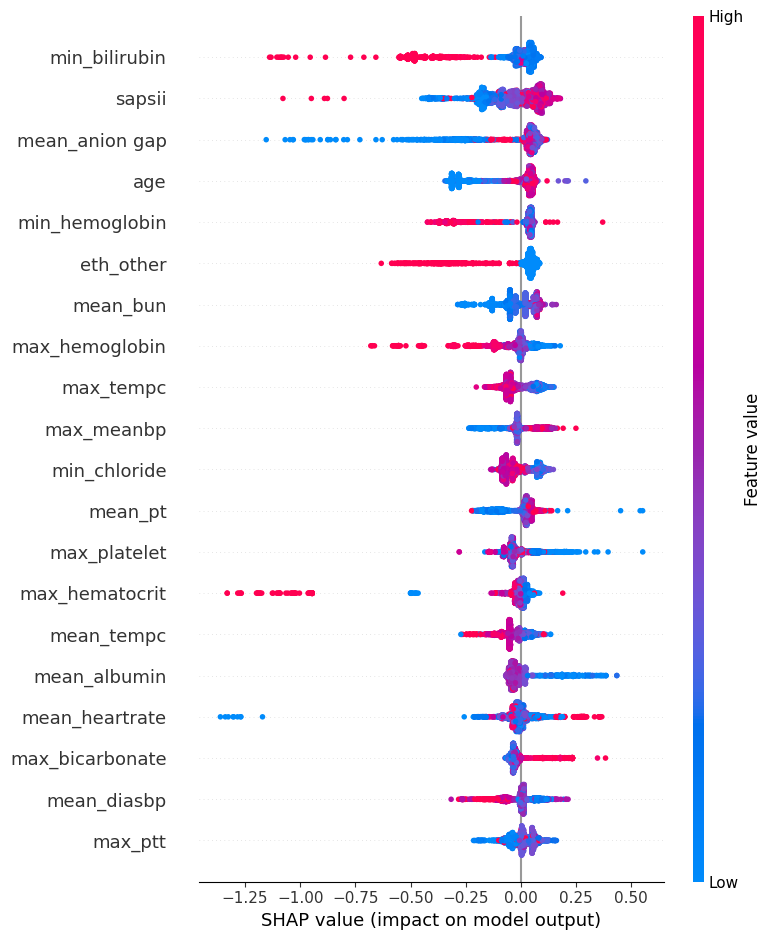

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


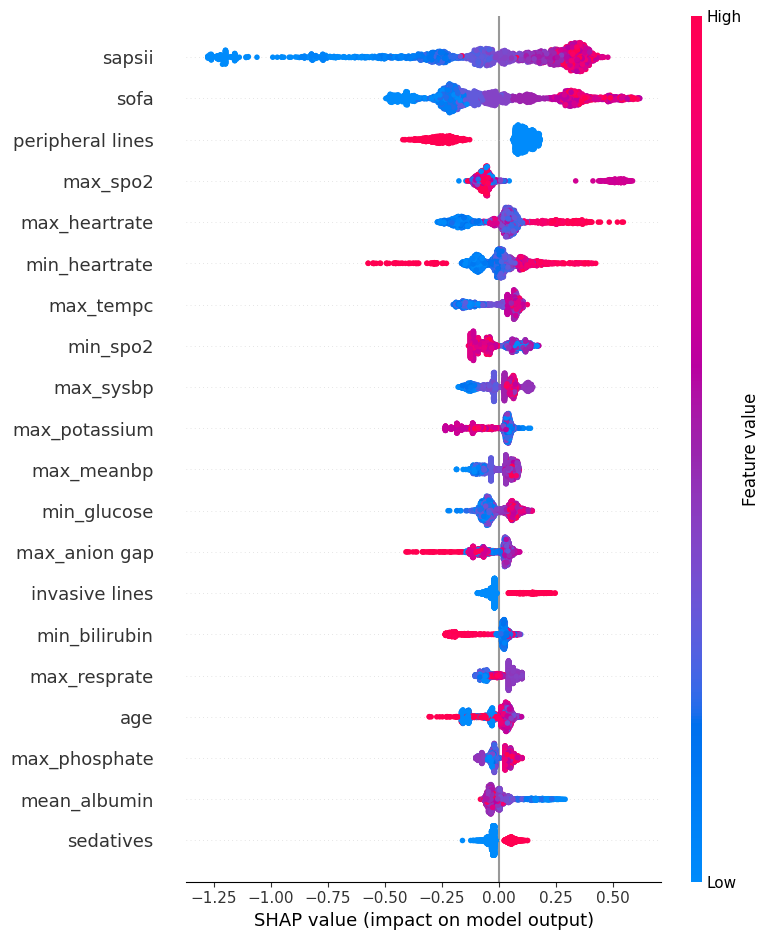

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


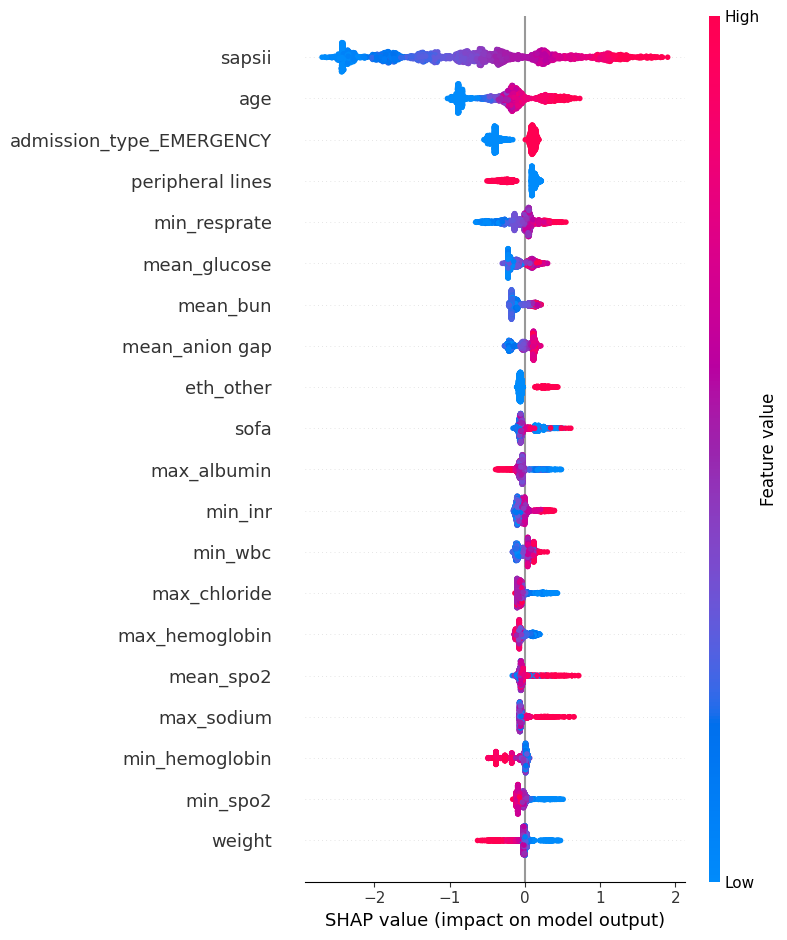

In [56]:
for label in y_train.columns.tolist()[::-1]:
    x_t, x_v, y_t, y_v = train_test_split(X_train, y_train[label], test_size=0.1, random_state=42)
    x_t, x_v = impute_and_scale(x_t, x_v)

    params = best_params[label]
    scale_weight = 1.*y_t.value_counts()[0]/y_t.value_counts()[1]
    params['scale_pos_weight'] = scale_weight

    model = XGBClassifier()
    model.set_params(**params)
    model.fit(x_t, y_t)
    calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
    calibrated_model.fit(x_v, y_v)

    # plots
    plot_shap(model, x_v, X_train.columns.to_list(), label)

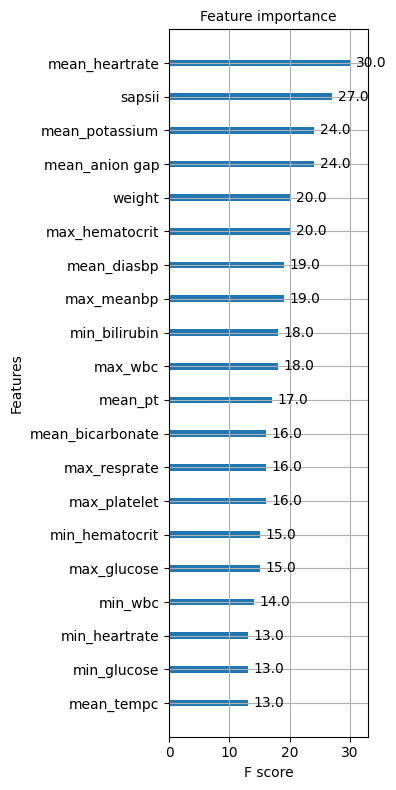

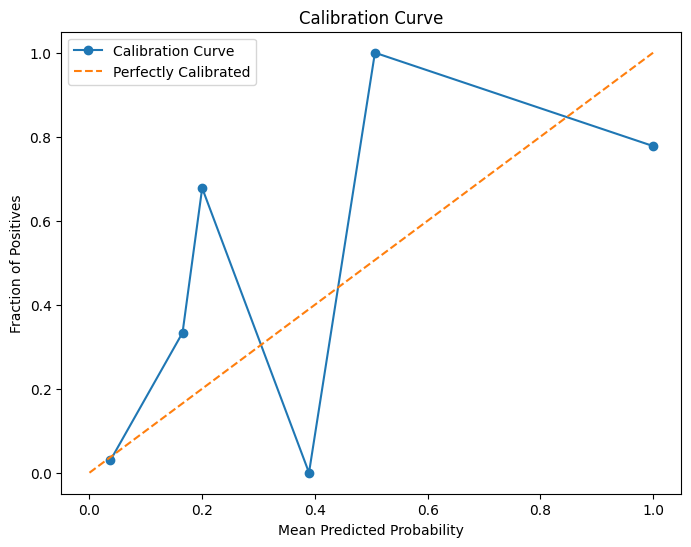

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


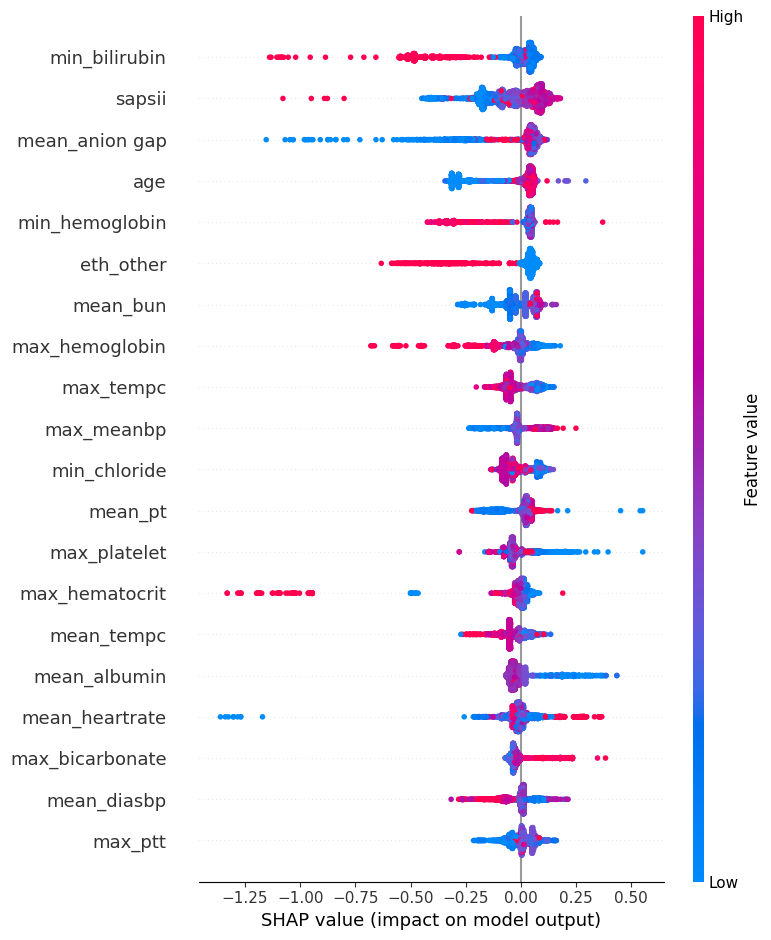

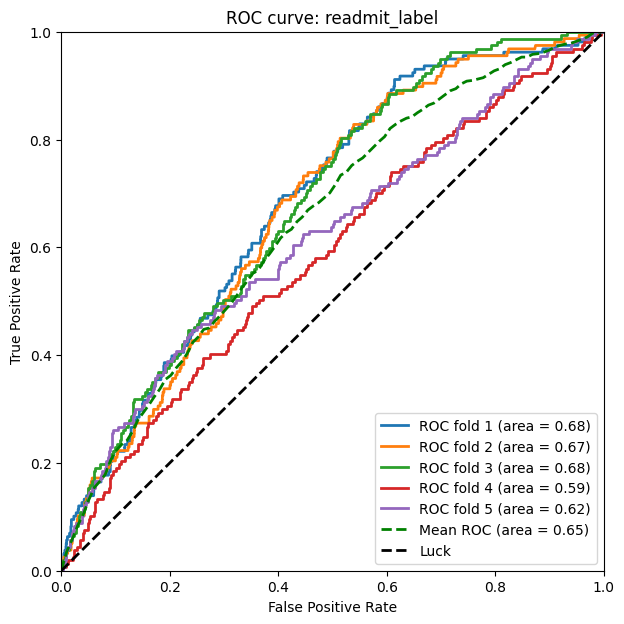

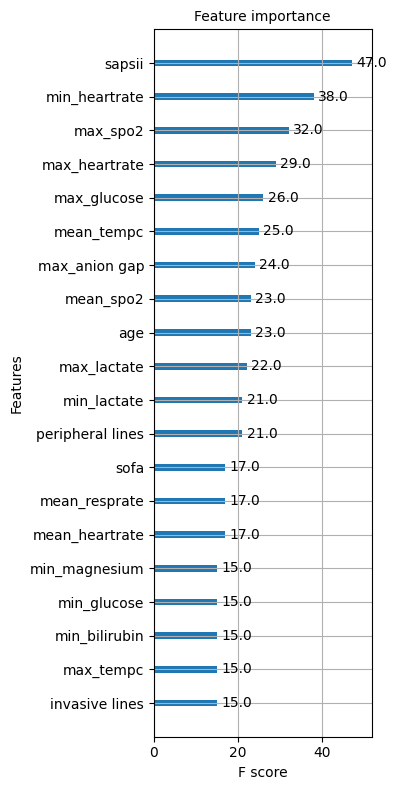

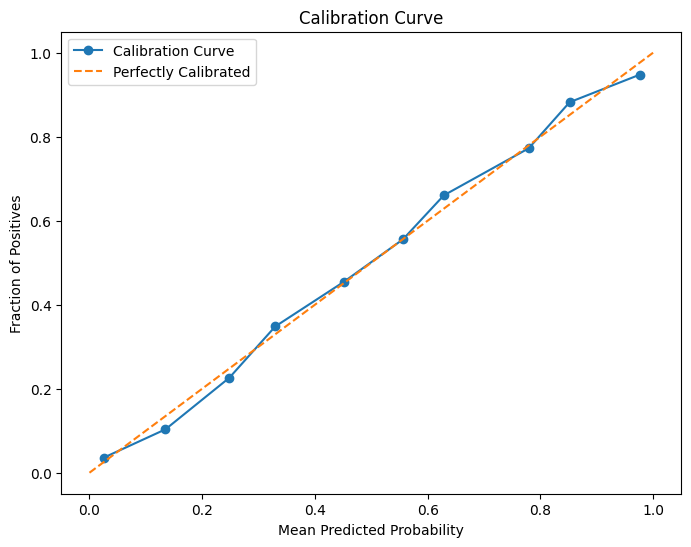

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


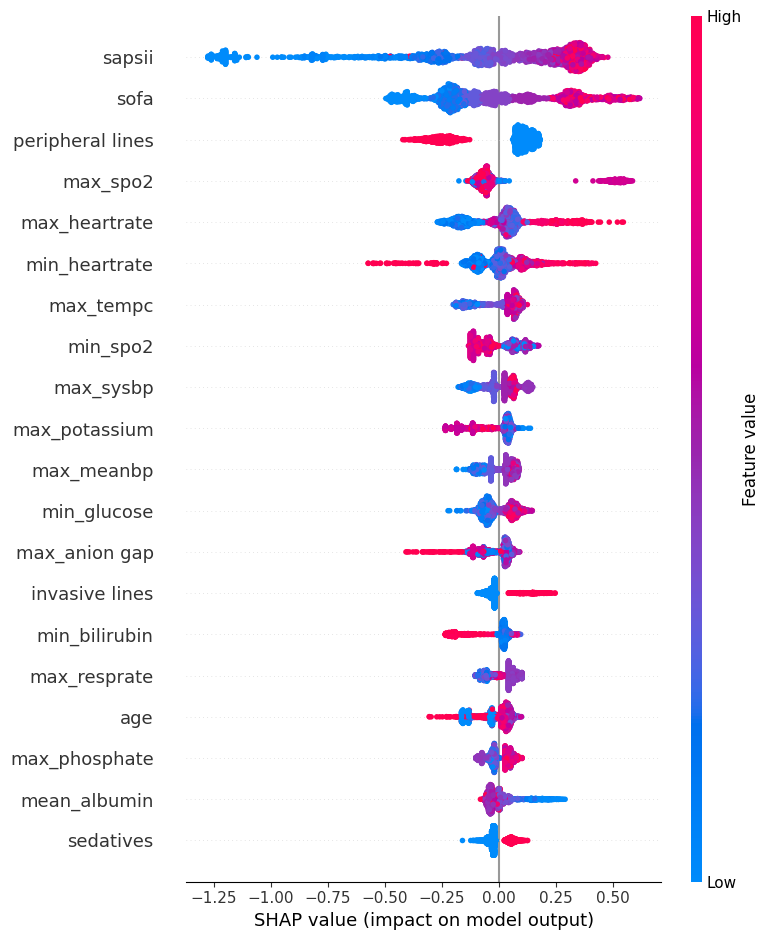

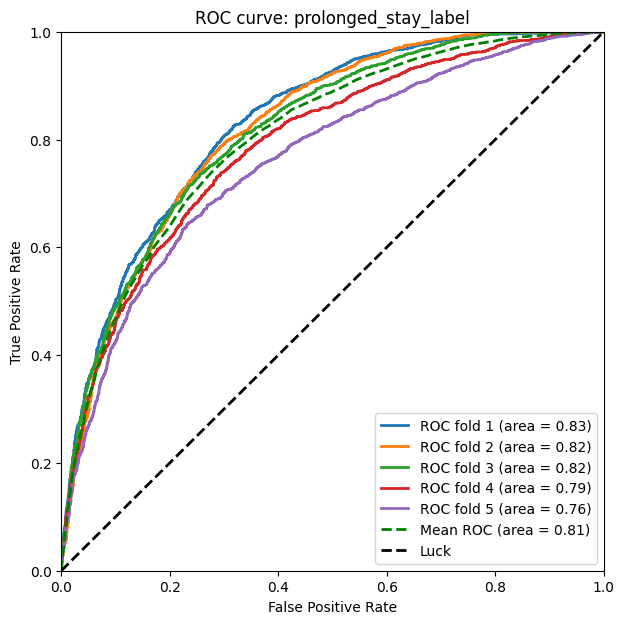

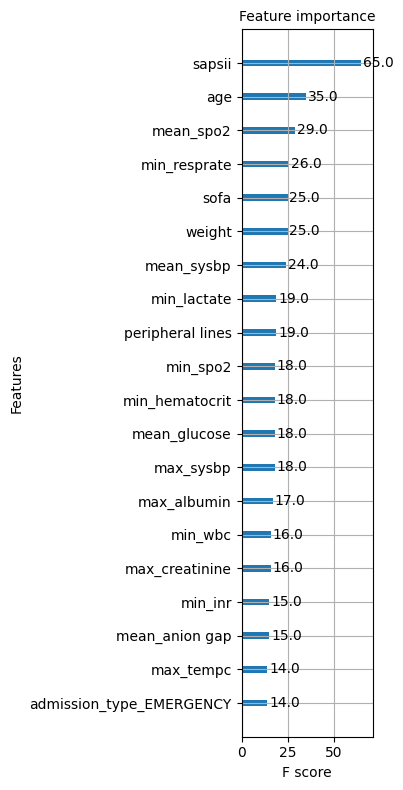

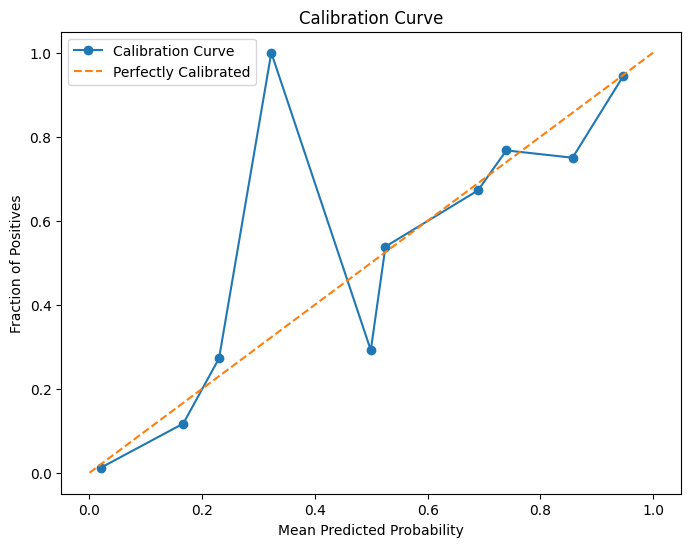

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


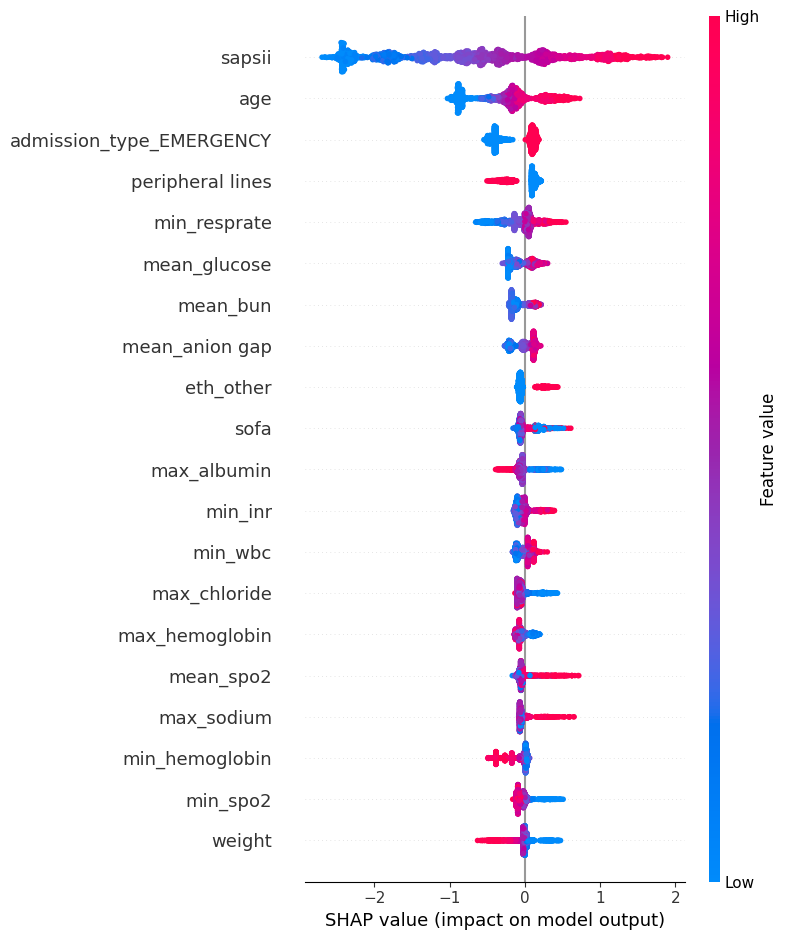

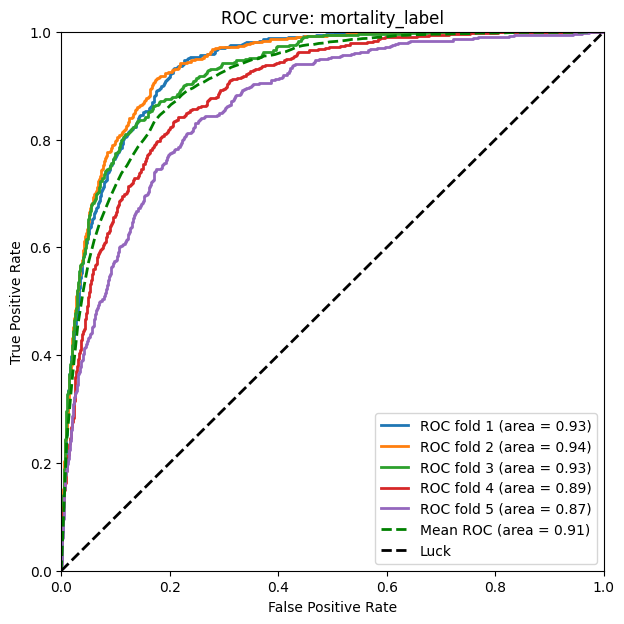

In [58]:
for label in y_train.columns.tolist()[::-1]:
    x_t, x_v, y_t, y_v = train_test_split(X_train, y_train[label], test_size=0.1, random_state=42)
    # x_t, x_v = impute_and_scale(x_t, x_v)

    params = best_params[label]
    scale_weight = 1.*y_t.value_counts()[0]/y_t.value_counts()[1]
    params['scale_pos_weight'] = scale_weight

    model = XGBClassifier()
    model.set_params(**params)
    model.fit(x_t, y_t)
    calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
    calibrated_model.fit(x_v, y_v)

    # plots
    my_plot_importance(model, (4,8))
    calibration_curve_plt(calibrated_model, x_t, y_t)
    plot_shap(model, x_v, X_train.columns.to_list(), label)

    k_fold_roc(params, label, X_train, y_train[label], 5)

In [ ]:
x_t, x_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
for label in y_train.columns.tolist()[::-1]:
    params = best_params[label]

    # scale weight of labels: number of negatives / nuber of positives
    scale_weight = 1.*y_t[label].value_counts()[0]/y_t[label].value_counts()[1]
    params['scale_pos_weight'] = scale_weight

    model = XGBClassifier()
    model.set_params(**params)
    imputer = AgeGenderImputer(numerical_columns)
    scaler = ColumnTransformer(
            transformers=[
                ('numerical', StandardScaler(), numerical_columns)
            ], remainder='passthrough')
    scaler.fit(x_t)

    pipeline = Pipeline(steps=[
                ("imputer", imputer),
                ("scaler", scaler),
                # ("smote", SMOTE(sampling_strategy='not minority', random_state=42)),
                ("model", model)
            ])

    pipeline.fit(X_train, y_train[label])
    model = pipeline['model']

    # Make predictions on the test data and evaluate
    # y_pred = pipeline.predict(X_test)
    # accuracy = accuracy_score(y_test[label], y_pred)
    # print(f"Accuracy {label}: {accuracy:.2f}", Counter(y_t[label]))

    # calibrated_model = CalibratedClassifierCV(pipeline, method='sigmoid', cv='prefit')
    # calibrated_model.fit(X_test, y_test[label])
    # calibration_curve_plt(calibrated_model, x_t, y_t[label])
    feature_importance(model, x_t)
    k_fold_roc(params, label, x_t, y_t, 5)

In [ ]:
X_train.columns.tolist()[113]

In [ ]:


model = XGBClassifier()
model.set_params(**params)

imputer = AgeGenderImputer(numerical_columns)
scaler = ColumnTransformer(
        transformers=[
            ('numerical', StandardScaler(), numerical_columns)
        ], remainder='passthrough')
scaler.fit(X_train)

pipeline = Pipeline(steps=[
            ("imputer", imputer),
            ("scaler", scaler),
            # ("smote", SMOTE(sampling_strategy='not minority', random_state=42)),
            ("model", model)
        ])

pipeline = CalibratedClassifierCV(pipeline, method='sigmoid', cv=3)
pipeline.fit(x_t, y_t[labels[0]])

# Create a SHAP explainer for XGBoost
explainer = shap.Explainer(pipeline)

# Calculate SHAP values for your data
shap_values = explainer(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train)


In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
a = Counter(y_v[labels[0]])
b = Counter(y_t[labels[0]])
print(a,b)

In [ ]:
from sklearn.feature_selection import RFECV


N = 10
x_t, x_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
for label in y_train.columns.tolist()[::-1]:
    model = XGBClassifier()
    model.set_params(**params)
    imputer = AgeGenderImputer(numerical_columns)
    scaler = ColumnTransformer(
            transformers=[
                ('numerical', StandardScaler(), numerical_columns)
            ], remainder='passthrough')
    scaler.fit(x_t)

    xgb_model = Pipeline(steps=[
                ("imputer", imputer),
                ("scaler", scaler),
                ("smote", SMOTE(sampling_strategy='not minority', random_state=42)),
                ("model", model)
            ])

    xgb_model.fit(x_t, y_t[label])

    # Get feature importances
    feature_importances = xgb_model['model'].feature_importances_

    # Sort features by importance
    sorted_indices = feature_importances.argsort()[::-1]

    # Select top N features
    top_features = sorted_indices[:N]

    feature_names = list(X_train.columns)
    selected_feature_names = [feature_names[idx] for idx in top_features]
    print(selected_feature_names)
    # Use top_features for training and testing
    # X_train_selected = x_t[:, top_features]
    # X_val_selected = x_v[:, top_features]

In [ ]:
from sklearn.inspection import permutation_importance

N = 10
x_t, x_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
for label in y_train.columns.tolist()[::-1]:
    model = XGBClassifier()
    model.set_params(**params)
    imputer = AgeGenderImputer(numerical_columns)
    scaler = ColumnTransformer(
            transformers=[
                ('numerical', StandardScaler(), numerical_columns)
            ], remainder='passthrough')
    scaler.fit(x_t)

    xgb_model = Pipeline(steps=[
                ("imputer", imputer),
                ("scaler", scaler),
                ("smote", SMOTE(sampling_strategy='not minority', random_state=42)),
                ("model", model)
            ])

    xgb_model.fit(x_t, y_t[label])

    # Compute permutation importance
    result = permutation_importance(xgb_model, x_v, y_v[label], n_repeats=10, random_state=42)

    # Get feature importances
    feature_importances = result.importances_mean

    # Sort features by importance
    sorted_indices = feature_importances.argsort()[::-1]

    # Select top N features
    top_features = sorted_indices[:N]
    feature_names = list(X_train.columns)
    selected_feature_names = [feature_names[idx] for idx in top_features]
    print(selected_feature_names)
    # Use top_features for training and testing
    # X_train_selected = X_train[:, top_features]
    # X_test_selected = X_test[:, top_features]

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
# from sklearn.pipeline import Pipeline

model = XGBClassifier()
model.set_params(**params)
imputer = AgeGenderImputer(numerical_columns)
scaler = ColumnTransformer(
        transformers=[
            ('numerical', StandardScaler(), numerical_columns)
        ], remainder='passthrough')
scaler.fit(x_t)

xgb_model = Pipeline(steps=[
            ("imputer", imputer),
            ("scaler", scaler),
            # ("smote", SMOTE(sampling_strategy='not minority', random_state=42)),
            ("classifier", model)
        ])

xgb_model.fit(x_t, y_t[label])

calibrated_model = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')

# Create an imblearn pipeline with calibration
# pipeline = Pipeline([
#     ('xgb', calibrated_model)
# ])

# Train the pipeline


calibrated_model.fit(x_v, y_v[label])

calibrated_probs = calibrated_model.predict_proba(X_test)[:, 1]


In [ ]:
for column_name in y_train.columns:
    column_counts = y_train[column_name].value_counts()
    print(f"Counts for {column_name}:\n{column_counts}\n")

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

for label in y_train.columns.tolist()[::-1]:
    x_t, x_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    params = best_params[label]

    # scale weight of labels: number of negatives / nuber of positives
    scale_weight = 1.*y_train[label].value_counts()[0]/y_train[label].value_counts()[1]
    params['scale_pos_weight'] = scale_weight

    model = XGBClassifier()
    model.set_params(**params)
    imputer = AgeGenderImputer(numerical_columns)
    scaler = ColumnTransformer(
            transformers=[
                ('numerical', StandardScaler(), numerical_columns)
            ], remainder='passthrough')
    scaler.fit(x_t)

    pipeline = Pipeline(steps=[
                ("imputer", imputer),
                ("scaler", scaler),
                # ("smote", SMOTE(random_state=42)),
                ("model", model)
            ])
    pipeline.fit(x_t, y_t)

    calibrated_pipeline = CalibratedClassifierCV(pipeline, method='sigmoid', cv=3)
    calibrated_pipeline.fit(x_v, y_v[label])

    # Predict probabilities using the calibrated pipeline
    calibrated_probabilities = calibrated_pipeline.predict_proba(x_v)[:, 1]

    # Calculate Brier score to evaluate calibration (lower is better)
    brier_score = brier_score_loss(y_v[label], calibrated_probabilities)
    calibration_curve_plt(calibrated_pipeline, x_v, y_v[label])
    print(f"Brier Score: {brier_score}")
    # roc(pipeline, X_test, y_test[label])

In [ ]:
# for column in y_train.columns:
#     # Count the number of NaN values in the column
#     num_nans = y_train[column].isna().sum()
#     if num_nans > 0:
#         # Print the column name and the number of NaN values
#         print(f"'{column}': {num_nans}")

In [ ]:
df = pd.concat([X_train, y_train], axis = 1)

# mortality in different ethnicities
for eth in ['eth_white', 'eth_black', 'eth_hispanic', 'eth_asian', 'eth_other']:
    text = eth + ': '
    count = df[(df[eth] == 1) & (df['mortality_label'] == 1)].shape[0]
    text += str(count) + ' died, out of ' + str(df[(df[eth] == 1)].shape[0]) + '. That\'s '
    percentage = round((count / df[(df[eth] == 1)].shape[0]) * 100, 2)
    total_percentage = round(count / df[(df['mortality_label'] == 1)].shape[0] * 100, 2)
    text += str(percentage) + '%, and ' + str(total_percentage) + '% of all dead'
    print(text)

# prolonged stay with newborns
count = df[(df['admission_type_NEWBORN'] == 1) & (df['prolonged_stay_label'] == 1)].shape[0]
percentage = round(count / df[(df['prolonged_stay_label'] == 1)].shape[0] * 100, 2)
print(percentage, count, df[(df['prolonged_stay_label'] == 1)].shape[0])

In [ ]:
labels = ['mortality_label', 'prolonged_stay_label', 'readmit_label']
for label in labels:
    best_params = {}
    x_t, x_v, y_t, y_v = train_test_split(X_train, y_train[label], test_size=0.2, random_state=42)
    print(label)
    model = XGBClassifier()
    imputer = AgeGenderImputer(numerical_columns)
    scaler = ColumnTransformer(
            transformers=[
                ('numerical', StandardScaler(), numerical_columns)
            ], remainder='passthrough')
    scaler.fit(x_t)
    pipeline = Pipeline(steps=[
            ("imputer", imputer),
            ("scaler", scaler),
            ("model", model)
        ])

    params = {
        'model__max_depth': [3, 4, 5, 6],
        'model__min_child_weight': [1, 3, 5]
    }
    cv_model = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='roc_auc')
    cv_model.fit(x_t, y_t)
    best_params.update(cv_model.best_params_)
    print(cv_model.best_params_)

    params = {
        'model__n_estimators': [50, 100, 150],
        'model__learning_rate': [0.5, 0.1, 0.01]
    }
    cv_model = GridSearchCV(estimator=cv_model.best_estimator_, param_grid=params, cv=3, scoring='roc_auc')
    cv_model.fit(x_t, y_t)
    best_params.update(cv_model.best_params_)
    print(cv_model.best_params_)

    params = {
        'model__gamma': [0.1, 0.5],
        'model__subsample': [0.5, 0.75, 1],
        'model__colsample_bytree': [0.75, 1]
    }
    cv_model = GridSearchCV(estimator=cv_model.best_estimator_, param_grid=params, cv=3, scoring='roc_auc')
    cv_model.fit(x_t, y_t)
    best_params.update(cv_model.best_params_)
    print(cv_model.best_params_)

    output_file = 'best_params_' + label + '.json'

    # Write the merged_dict to a JSON file
    with open(output_file, 'w') as json_file:
        json.dump(best_params, json_file)

In [ ]:
    #    'objective':'binary:logistic',
    #     'scale_pos_weight':scale_weight,
    #     'min_child_weight': 5,
    #     'seed' : 1,
    #     'n_estimators' : 100,
    #     'max_depth': 3,
    #     'learning_rate':0.1,
    #     'gamma':0.1,
    #     'subsample': 0.6,
    #     'colsample_bytree': 0.7,
    #     'reg_alpha': 0.1

labels = ['mortality_label', 'prolonged_stay_label', 'readmit_label']
for label in labels:
    x_t, x_v, y_t, y_v = train_test_split(X_train, y_train[label], test_size=0.2, random_state=42)
    print(label)
    model = XGBClassifier()
    imputer = AgeGenderImputer(numerical_columns)
    scaler = ColumnTransformer(
            transformers=[
                ('numerical', StandardScaler(), numerical_columns)
            ], remainder='passthrough')
    scaler.fit(X_train)
    pipeline = Pipeline(steps=[
            ("imputer", imputer),
            ("scaler", scaler),
            ("model", model)
        ])

    params = {
        'model__max_depth': [3, 4, 5, 6],
        'model__min_child_weight': [1, 3, 5]
    }
    cv_model = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='roc_auc')
    cv_model.fit(x_t, y_t)
    print(cv_model.best_params_)

    params = {
        'model__n_estimators': [50, 100, 150],
        'model__learning_rate': [0.5, 0.1, 0.01]
    }
    cv_model = GridSearchCV(estimator=cv_model.best_estimator_, param_grid=params, cv=3, scoring='roc_auc')
    cv_model.fit(x_t, y_t)
    print(cv_model.best_params_)

    params = {
        'model__gamma': [0.1, 0.5],
        'model__subsample': [0.5, 0.75, 1],
        'model__colsample_bytree': [0.75, 1]
    }
    cv_model = GridSearchCV(estimator=cv_model.best_estimator_, param_grid=params, cv=3, scoring='roc_auc')
    cv_model.fit(x_t, y_t)
    print(label, cv_model.best_params_)


# cv_model = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='roc_auc')

# cv_model.fit(X_train, y_train)

# labels = ['mortality_label', 'prolonged_stay_label', 'readmit_label']
# for label in labels:
#     x_t, x_v, y_t, y_v = train_test_split(X_train, y_train[label], test_size=0.2, random_state=42)
#     print(label)
#     model = XGBClassifier()
#     imputer = AgeGenderImputer(numerical_columns)
#     scaler = ColumnTransformer(
#             transformers=[
#                 ('numerical', StandardScaler(), numerical_columns)
#             ], remainder='passthrough')
#     scaler.fit(X_train)
#     pipeline = Pipeline(steps=[
#             ("imputer", imputer),
#             ("scaler", scaler),
#             ("model", model)
#         ])

#     params = {
#         'model__max_depth': [3, 4],
#         'model__min_child_weight': [1]
#     }
#     cv_model = GridSearchCV(estimator=pipeline, param_grid=params, cv=3, scoring='roc_auc')
#     cv_model.fit(x_t, y_t)
#     print(cv_model.best_params_)

#     params = {
#         'model__n_estimators': [50],
#         'model__learning_rate': [0.5, 0.1]
#     }
#     cv_model = GridSearchCV(estimator=cv_model.best_estimator_, param_grid=params, cv=3, scoring='roc_auc')
#     cv_model.fit(x_t, y_t)
#     print(cv_model.best_params_)

#     params = {
#         'model__gamma': [0.1],
#         'model__subsample': [0.5],
#         'model__colsample_bytree': [0.75]
#     }
#     cv_model = GridSearchCV(estimator=cv_model.best_estimator_, param_grid=params, cv=3, scoring='roc_auc')
#     cv_model.fit(x_t, y_t)
#     print(cv_model.best_params_)


In [ ]:
columns_to_drop = ['admittime', 'dischtime', 'ethnicity', 'dob', 'dod', 'deathtime', 'mort', 'subject_id', 'hadm_id', 'los_hosp_hr']
merged_df = merged_df.drop(columns_to_drop, axis=1)





columns_with_na = filter_df.columns[filter_df.isna().any()].tolist()
columns_with_na = [string for string in columns_with_na if 'min_' not in string]
columns_with_na = [string for string in columns_with_na if 'max_' not in string]
columns_with_na = [string for string in columns_with_na if 'mean_' not in string]

# Display the count of NaNs in each column
print(columns_with_na)